In [1]:
import json
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import inflect
import time
from tqdm import tqdm
import collections
import gensim
import pickle
from gensim.matutils import corpus2csc
from gensim.corpora import Dictionary
import tqdm
engine = inflect.engine()

In [2]:
recipes = json.load(open('../resources/all_recipes_repr.json'))

In [3]:
substitutes = [("butter", "margarine"), 
           ("zucchini", "eggplant"), 
           ("bacon", "ham"), 
           ("oil", "lard"), 
           ("heavy cream", "whipping cream"),
           ("turbinado sugar", "sugar substitute"),
           ("pistachio nut", "almond"),
           ("mushroom", "shiitake")
          ]
bad_idea = [("cream cheese", "apple pie filling"),
           ("cream cheese", "skor candy bar"),
           ("tabasco pepper sauce", "crab"),
           ("parsley", "elbow macaroni"),
           ("parmesan cheese", "mushroom"),
           ("mushroom", "tortellini")]

#### unique ingredients representations

In [4]:
ings = set()

for x in recipes :
    ings.update(x)

In [5]:
def singularize(word):
    ingr = engine.singular_noun(word)
    return word if (not ingr) else ingr

def clean_ing_word(word) : return singularize(word).lower()

def clean_whole_ing(ing) : return " ".join([clean_ing_word(word) for word in ing.split(" ")])

Word2Vec training

In [6]:
def evaluate_embeddings() :
    score = 0
    for s in substitutes :
        score += model.wv.similarity(s[0], s[1])
    
    for bd in bad_idea :
        score -= model.wv.similarity(bd[0], bd[1])
        
    return score

In [10]:
perf = dict()

nb_epochs = 25
nb_trials = 4

for e in range(1, nb_trials) :
    perf[e] = []

for trials in range(1, nb_trials) :
    model = gensim.models.Word2Vec(recipes, min_count=2)

    for epoch in tqdm.tqdm(np.arange(1, nb_epochs)) :
        print("model created")
        model.train(recipes, total_examples=len(recipes), epochs=1)
        print("model trained")
        score = evaluate_embeddings()
        print("score for", epoch, "epocs : ",  score) 
        perf[epoch] += [score]

  0%|          | 0/24 [00:00<?, ?it/s]

model created


  4%|▍         | 1/24 [00:02<00:54,  2.38s/it]

model trained
score for 1 epocs :  1.7216899085599504
model created


  8%|▊         | 2/24 [00:04<00:53,  2.43s/it]

model trained
score for 2 epocs :  1.721742248922573
model created


 12%|█▎        | 3/24 [00:07<00:52,  2.49s/it]

model trained
score for 3 epocs :  1.649706156023302
model created


 17%|█▋        | 4/24 [00:10<00:52,  2.63s/it]

model trained
score for 4 epocs :  1.7212126369757734
model created


 21%|██        | 5/24 [00:13<00:51,  2.70s/it]

model trained
score for 5 epocs :  1.7209801931018045
model created


 25%|██▌       | 6/24 [00:16<00:50,  2.80s/it]

model trained
score for 6 epocs :  1.6599999881562155
model created


 29%|██▉       | 7/24 [00:19<00:48,  2.88s/it]

model trained
score for 7 epocs :  1.7472793422531612
model created


 33%|███▎      | 8/24 [00:22<00:46,  2.90s/it]

model trained
score for 8 epocs :  1.8102917511132013
model created


 38%|███▊      | 9/24 [00:25<00:44,  2.93s/it]

model trained
score for 9 epocs :  1.7325361810098003
model created


 42%|████▏     | 10/24 [00:28<00:41,  2.98s/it]

model trained
score for 10 epocs :  1.6825936021636085
model created


 46%|████▌     | 11/24 [00:31<00:38,  2.96s/it]

model trained
score for 11 epocs :  1.707766592939642
model created


 50%|█████     | 12/24 [00:34<00:35,  2.99s/it]

model trained
score for 12 epocs :  1.7117911388171203
model created


 54%|█████▍    | 13/24 [00:37<00:32,  2.98s/it]

model trained
score for 13 epocs :  1.70721537896832
model created


 58%|█████▊    | 14/24 [00:40<00:29,  2.96s/it]

model trained
score for 14 epocs :  1.7309889934328646
model created


 62%|██████▎   | 15/24 [00:43<00:26,  2.98s/it]

model trained
score for 15 epocs :  1.7718915680465972
model created


 67%|██████▋   | 16/24 [00:46<00:24,  3.09s/it]

model trained
score for 16 epocs :  1.7661665043045953
model created


 71%|███████   | 17/24 [00:49<00:21,  3.03s/it]

model trained
score for 17 epocs :  1.7730201188241304
model created


 75%|███████▌  | 18/24 [00:52<00:17,  2.97s/it]

model trained
score for 18 epocs :  1.8618739715486756
model created


 79%|███████▉  | 19/24 [00:55<00:14,  2.97s/it]

model trained
score for 19 epocs :  1.9021899882018047
model created


 83%|████████▎ | 20/24 [00:58<00:11,  2.92s/it]

model trained
score for 20 epocs :  1.779832835208925
model created


 88%|████████▊ | 21/24 [01:01<00:08,  2.90s/it]

model trained
score for 21 epocs :  1.8721692463136264
model created


 92%|█████████▏| 22/24 [01:03<00:05,  2.88s/it]

model trained
score for 22 epocs :  1.7838741676379386
model created


 96%|█████████▌| 23/24 [01:06<00:02,  2.87s/it]

model trained
score for 23 epocs :  1.780480397235777
model created


100%|██████████| 24/24 [01:09<00:00,  2.88s/it]

model trained
score for 24 epocs :  1.9345407560444423



  0%|          | 0/24 [00:00<?, ?it/s]

model created


  4%|▍         | 1/24 [00:03<01:09,  3.01s/it]

model trained
score for 1 epocs :  1.5696150471340107
model created


  8%|▊         | 2/24 [00:06<01:08,  3.09s/it]

model trained
score for 2 epocs :  1.5836235831720151
model created


 12%|█▎        | 3/24 [00:09<01:05,  3.13s/it]

model trained
score for 3 epocs :  1.6541141321555228
model created


 17%|█▋        | 4/24 [00:12<01:02,  3.12s/it]

model trained
score for 4 epocs :  1.6208546532471515
model created


 21%|██        | 5/24 [00:16<01:00,  3.21s/it]

model trained
score for 5 epocs :  1.5497614860869633
model created


 25%|██▌       | 6/24 [00:19<00:58,  3.24s/it]

model trained
score for 6 epocs :  1.7961425639526412
model created


 29%|██▉       | 7/24 [00:22<00:53,  3.12s/it]

model trained
score for 7 epocs :  1.7270217875419969
model created


 33%|███▎      | 8/24 [00:25<00:50,  3.13s/it]

model trained
score for 8 epocs :  1.7728107337116883
model created


 38%|███▊      | 9/24 [00:28<00:46,  3.11s/it]

model trained
score for 9 epocs :  1.8498091489616861
model created


 42%|████▏     | 10/24 [00:31<00:44,  3.18s/it]

model trained
score for 10 epocs :  1.818109030199885
model created


 46%|████▌     | 11/24 [00:34<00:41,  3.16s/it]

model trained
score for 11 epocs :  1.7799968376630528
model created


 50%|█████     | 12/24 [00:38<00:38,  3.19s/it]

model trained
score for 12 epocs :  1.8054032312372068
model created


 54%|█████▍    | 13/24 [00:41<00:34,  3.14s/it]

model trained
score for 13 epocs :  1.7581715485126326
model created


 58%|█████▊    | 14/24 [00:43<00:30,  3.04s/it]

model trained
score for 14 epocs :  1.870504604994543
model created


 62%|██████▎   | 15/24 [00:46<00:26,  2.98s/it]

model trained
score for 15 epocs :  1.8668610409857156
model created


 67%|██████▋   | 16/24 [00:49<00:23,  2.94s/it]

model trained
score for 16 epocs :  1.8845922057040638
model created


 71%|███████   | 17/24 [00:52<00:20,  2.90s/it]

model trained
score for 17 epocs :  1.7617005506092824
model created


 75%|███████▌  | 18/24 [00:55<00:17,  2.90s/it]

model trained
score for 18 epocs :  1.798714844891618
model created


 79%|███████▉  | 19/24 [00:58<00:14,  2.90s/it]

model trained
score for 19 epocs :  1.8682472439908908
model created


 83%|████████▎ | 20/24 [01:01<00:11,  2.89s/it]

model trained
score for 20 epocs :  1.6762772946571018
model created


 88%|████████▊ | 21/24 [01:03<00:08,  2.86s/it]

model trained
score for 21 epocs :  1.8548322971026523
model created


 92%|█████████▏| 22/24 [01:06<00:05,  2.86s/it]

model trained
score for 22 epocs :  1.8517785566249771
model created


 96%|█████████▌| 23/24 [01:09<00:02,  2.85s/it]

model trained
score for 23 epocs :  1.861548652270018
model created


100%|██████████| 24/24 [01:12<00:00,  2.86s/it]

model trained
score for 24 epocs :  1.9093501053703306



  0%|          | 0/24 [00:00<?, ?it/s]

model created


  4%|▍         | 1/24 [00:02<01:07,  2.94s/it]

model trained
score for 1 epocs :  1.6213339554696942
model created


  8%|▊         | 2/24 [00:05<01:03,  2.90s/it]

model trained
score for 2 epocs :  1.6262089381899119
model created


 12%|█▎        | 3/24 [00:09<01:03,  3.01s/it]

model trained
score for 3 epocs :  1.73603639598647
model created


 17%|█▋        | 4/24 [00:12<01:01,  3.08s/it]

model trained
score for 4 epocs :  1.7415236438013668
model created


 21%|██        | 5/24 [00:15<00:59,  3.16s/it]

model trained
score for 5 epocs :  1.8058423209067844
model created


 25%|██▌       | 6/24 [00:18<00:55,  3.08s/it]

model trained
score for 6 epocs :  1.7550204341419797
model created


 29%|██▉       | 7/24 [00:21<00:53,  3.14s/it]

model trained
score for 7 epocs :  1.7228344782082
model created


 33%|███▎      | 8/24 [00:24<00:50,  3.13s/it]

model trained
score for 8 epocs :  1.7904275552224713
model created


 38%|███▊      | 9/24 [00:28<00:47,  3.20s/it]

model trained
score for 9 epocs :  1.7477359859857629
model created


 42%|████▏     | 10/24 [00:31<00:44,  3.17s/it]

model trained
score for 10 epocs :  1.5424814383779093
model created


 46%|████▌     | 11/24 [00:34<00:41,  3.18s/it]

model trained
score for 11 epocs :  1.7723642423017782
model created


 50%|█████     | 12/24 [00:37<00:38,  3.21s/it]

model trained
score for 12 epocs :  1.8138438431357864
model created


 54%|█████▍    | 13/24 [00:40<00:34,  3.16s/it]

model trained
score for 13 epocs :  1.8201669390583395
model created


 58%|█████▊    | 14/24 [00:43<00:31,  3.10s/it]

model trained
score for 14 epocs :  1.8280548243119565
model created


 62%|██████▎   | 15/24 [00:47<00:28,  3.13s/it]

model trained
score for 15 epocs :  1.8598014391454172
model created


 67%|██████▋   | 16/24 [00:49<00:24,  3.06s/it]

model trained
score for 16 epocs :  1.8213157916734324
model created


 71%|███████   | 17/24 [00:52<00:21,  3.03s/it]

model trained
score for 17 epocs :  1.8352651383420997
model created


 75%|███████▌  | 18/24 [00:55<00:17,  2.99s/it]

model trained
score for 18 epocs :  1.7971429242580264
model created


 79%|███████▉  | 19/24 [00:58<00:14,  2.93s/it]

model trained
score for 19 epocs :  1.8004359579386051
model created


 83%|████████▎ | 20/24 [01:01<00:11,  2.93s/it]

model trained
score for 20 epocs :  1.7780431970741175
model created


 88%|████████▊ | 21/24 [01:04<00:08,  2.89s/it]

model trained
score for 21 epocs :  1.8369819197629695
model created


 92%|█████████▏| 22/24 [01:07<00:05,  2.95s/it]

model trained
score for 22 epocs :  1.851269965926548
model created


 96%|█████████▌| 23/24 [01:10<00:02,  2.97s/it]

model trained
score for 23 epocs :  1.7679253200187848
model created


100%|██████████| 24/24 [01:13<00:00,  2.99s/it]

model trained
score for 24 epocs :  1.8263552362142377


In [11]:
perf

{1: [],
 2: [],
 3: [1.7216899085599504,
  1.721742248922573,
  1.649706156023302,
  1.7212126369757734,
  1.7209801931018045,
  1.6599999881562155,
  1.7472793422531612,
  1.8102917511132013,
  1.7325361810098003,
  1.6825936021636085,
  1.707766592939642,
  1.7117911388171203,
  1.70721537896832,
  1.7309889934328646,
  1.7718915680465972,
  1.7661665043045953,
  1.7730201188241304,
  1.8618739715486756,
  1.9021899882018047,
  1.779832835208925,
  1.8721692463136264,
  1.7838741676379386,
  1.780480397235777,
  1.9345407560444423,
  1.5696150471340107,
  1.5836235831720151,
  1.6541141321555228,
  1.6208546532471515,
  1.5497614860869633,
  1.7961425639526412,
  1.7270217875419969,
  1.7728107337116883,
  1.8498091489616861,
  1.818109030199885,
  1.7799968376630528,
  1.8054032312372068,
  1.7581715485126326,
  1.870504604994543,
  1.8668610409857156,
  1.8845922057040638,
  1.7617005506092824,
  1.798714844891618,
  1.8682472439908908,
  1.6762772946571018,
  1.8548322971026523,
 

In [8]:
for epoch in tqdm.tqdm(np.arange(1, 15)) :
    model = gensim.models.Word2Vec(recipes, min_count=2)
    print("model created")
    model.train(recipes, total_examples=len(recipes), epochs=epoch)
    print("model trained")
    print("score for", epoch, "epocs : ",  evaluate_embeddings())    

  0%|          | 0/14 [00:00<?, ?it/s]

model created


  7%|▋         | 1/14 [00:13<03:01, 13.97s/it]

model trained
score for 1 epocs :  1.5190284903559919
model created


 14%|█▍        | 2/14 [00:35<03:13, 16.16s/it]

model trained
score for 2 epocs :  1.6492678917214216
model created


 21%|██▏       | 3/14 [01:00<03:26, 18.74s/it]

model trained
score for 3 epocs :  1.6784182789527238
model created


 29%|██▊       | 4/14 [01:26<03:31, 21.10s/it]

model trained
score for 4 epocs :  1.6842952048816682
model created


 36%|███▌      | 5/14 [01:55<03:31, 23.52s/it]

model trained
score for 5 epocs :  1.6320249844394423
model created


 43%|████▎     | 6/14 [02:27<03:28, 26.08s/it]

model trained
score for 6 epocs :  1.7710129884843715
model created


 50%|█████     | 7/14 [03:04<03:25, 29.38s/it]

model trained
score for 7 epocs :  1.7448615754263512
model created


 57%|█████▋    | 8/14 [03:44<03:15, 32.56s/it]

model trained
score for 8 epocs :  1.7393188741919527
model created


 64%|██████▍   | 9/14 [04:26<02:56, 35.34s/it]

model trained
score for 9 epocs :  1.7785947530061577
model created


 71%|███████▏  | 10/14 [05:11<02:32, 38.05s/it]

model trained
score for 10 epocs :  1.7632501610482276
model created


 79%|███████▊  | 11/14 [05:58<02:02, 40.76s/it]

model trained
score for 11 epocs :  1.7727608396999528
model created


 86%|████████▌ | 12/14 [06:47<01:26, 43.39s/it]

model trained
score for 12 epocs :  1.7534779170418184
model created


 93%|█████████▎| 13/14 [07:40<00:46, 46.29s/it]

model trained
score for 13 epocs :  1.7602114560309272
model created


100%|██████████| 14/14 [08:38<00:00, 49.58s/it]

model trained
score for 14 epocs :  1.7923529564747418


In [78]:
start_time = time.time()
model = gensim.models.Word2Vec(recipes, min_count=2)

time_after_creation = time.time()
print("creation of model :", time_after_creation - start_time, "sec.")

model.train(recipes, total_examples=len(recipes), epochs=25)

time_after_training = time.time()
print("model training :", time_after_training - time_after_creation, "sec.")

model.save('../resources/food_embeddings.bin')

time_after_saving = time.time()
print("model saving :", time_after_saving - time_after_training, "sec.")

creation of model : 11.82779598236084 sec.
model training : 64.66780853271484 sec.
model saving : 0.019726276397705078 sec.


In [79]:
model = gensim.models.Word2Vec.load('../resources/food_embeddings.bin')
vocab = list(model.wv.vocab)

#### coocurences

In [80]:
ing_coocs   = np.zeros((len(ings), len(ings)))
ing_indices = dict([(i, e) for e, i in enumerate(vocab)])  

for r in tqdm.tqdm(recipes) :
    for i, ing1 in enumerate(r) :
        idx1 = ing_indices[ing1]                
        ing_coocs[idx1, idx1] += 1
            
        for ing2 in r[i+1:] :
            idx2 = ing_indices[ing2]    
            ing_coocs[idx1, idx2] += 1
            ing_coocs[idx2, idx1] += 1

100%|██████████| 811228/811228 [00:36<00:00, 22025.84it/s]


In [149]:
def get_ing_coocs(ing1, ing2) :
    idx1 = ing_indices[ing1]
    idx2 = ing_indices[ing2]
    return ing_coocs[idx1, idx2]

def are_complements(ing1, ing2, thresh=0.2) :
    
    idx1 = ing_indices[ing1]
    idx2 = ing_indices[ing2]
    
    occ1 = ing_coocs[idx1, idx1]
    occ2 = ing_coocs[idx2, idx2]
    
    prop = get_ing_coocs(ing1, ing2) / min(occ1, occ2)
    
    return prop, prop > thresh

def augmented_sim(ing1, min_sim=0.45, filter_name=True) :
    candidates = model.wv.most_similar(ing1, topn=20)
    retained = [c for c in candidates if not are_complements(ing1, c[0])[1] and 
                (not ing1 in c[0]) and 
               (not c[0] in ing1) and 
               (c[1] > min_sim)]
    return retained

#### Ingredients reduction

In [105]:
one_word_ings = [ing for ing in vocab if len(ing.split(" ")) == 1]
ing_to_sub = dict()

for ing in tqdm.tqdm(vocab) :
    if len(ing.split(" ")) != 1 :
        
        spotted_sub = []
        for owi in one_word_ings :
            if owi in ing :
                spotted_sub += [owi]
                
        if len(spotted_sub) == 1:
            ing_to_sub[ing] = spotted_sub[0]

print(len(ing_to_sub))          
sub_to_ing = dict()

for k in ing_to_sub :
    
    if ing_to_sub[k] in sub_to_ing :
        sub_to_ing[ing_to_sub[k]] += [k]
    else :
        sub_to_ing[ing_to_sub[k]] = [k]

100%|██████████| 1521/1521 [00:00<00:00, 30669.96it/s]

323
115


#### ingredient_to_ref

In [181]:
def ref(ing) :
    matches = []
    
    #build matches using full name ingredients
    for i in vocab :
        if i in ing :
            matches.append(i)
                        
    #sort matchings 
    matches = sorted(matches, key = lambda x : len(x.split(" ")), reverse=True)
    
    max_len = len(matches[0].split(" "))    
    matches = [m for m in matches if len(m.split(" ")) == max_len]
                  
    m_occs = [(m, ing_coocs[ing_indices[m], ing_indices[m]]) for m in matches]
    return sorted(m_occs, key=lambda x : x[1], reverse=True)[0][0]
    #return matches[0]

def to_model_ings(ings) :
    return [ref(i) for i in ings]

#### Trying real ingredients from real oliver

In [116]:
jo_ings = ["olive oil", 
           "1 x 1.5 kg whole free-range chicken", 
           "4 onions", 
           "4 carrots", 
           "2 cloves of garlic", 
           "½ a bunch of fresh rosemary", 
           "1 heaped tablespoon plain flour",
           "300 ml white wine",
           "200 ml organic chicken stock",
           "600 g potatoes",
           "2 handfuls of red and green grapes",
           "a few sprigs of fresh flat-leaf parsley"
          ]

In [168]:
to_model_ings(jo_ings)

['oil', 'olive']
['chicken']
['onion']
['carrot']
['garlic', 'clove']
['rosemary', 'bun', 'rose']
['plain flour']
['white wine']
['chicken stock']
['potato']
['green', 'grape', 'hand']
['parsley']


[('oil', 53047.0),
 ('chicken', 23885.0),
 ('onion', 210484.0),
 ('carrot', 58550.0),
 ('garlic', 53822.0),
 ('rosemary', 18446.0),
 ('plain flour', 4576.0),
 ('white wine', 25821.0),
 ('chicken stock', 18853.0),
 ('potato', 43850.0),
 ('green', 2318.0),
 ('parsley', 71547.0)]

In [162]:
to_model_ings(jo_ings)

['oil', 'olive']
['chicken']
['onion']
['carrot']
['garlic', 'clove']
['rosemary', 'bun', 'rose']
['plain flour']
['white wine']
['chicken stock']
['potato']
['green', 'grape', 'hand']
['parsley']


['oil',
 'chicken',
 'onion',
 'carrot',
 'garlic',
 'rosemary',
 'plain flour',
 'white wine',
 'chicken stock',
 'potato',
 'green',
 'parsley']

#### compute ingredients swaps and save them

In [172]:
replacements = dict()

for ing in vocab :
    print(ing)
    print(augmented_sim(ing))
    print()
    replacements[ing] = augmented_sim(ing)
    
replacements

salt
[]

cream cheese
[('neufchatel cheese', 0.6909483075141907), ('butter pecan ice cream', 0.5230361223220825), ('apple pie filling', 0.520905613899231), ('skor candy bar', 0.49778613448143005), ('hershey bar', 0.45577165484428406), ('potato chip', 0.4541632831096649), ('chocolate candy bar', 0.4515422582626343), ('marshmallow cream', 0.45134788751602173), ('milk chocolate candy bar', 0.4504110813140869)]

onion
[]

olive oil salad
[('sunflower oil', 0.5193564891815186), ('vegetable oil', 0.4855749309062958)]

thyme
[]

shrimp
[('fish', 0.6485452651977539), ('lobster', 0.6075106859207153), ('dungeness crab', 0.6071500182151794), ('fish fillet', 0.5993616580963135), ('conch', 0.5896091461181641), ('cod', 0.5597484111785889), ('catfish', 0.5476991534233093), ('snapper', 0.5444254875183105), ('sea bass', 0.5387033224105835), ('chicken breast', 0.5291150212287903), ('flounder', 0.5053536891937256), ('crab', 0.5011447668075562), ('fillet', 0.4885849356651306), ('white fish', 0.48370033502

date
[('cranberry', 0.6328704953193665), ('raisin', 0.6156296133995056), ('currant', 0.6033748388290405), ('cherry', 0.5952972173690796), ('apricot', 0.5853949785232544), ('muesli', 0.5391825437545776), ('maple syrup', 0.5385178923606873), ('fruit', 0.5343691110610962), ('pear', 0.5213215947151184), ('icing sugar', 0.5112935900688171), ('persimmon', 0.4999871850013733), ('coconut macaroon', 0.4971429407596588), ('chocolate bit', 0.49447762966156006), ('banana', 0.493820458650589), ('chocolate chip', 0.492967426776886), ('coconut yogurt', 0.4820619821548462), ('seedless raisin', 0.47593533992767334), ('applesauce', 0.4756450355052948), ('brown rice cereal', 0.4715484380722046)]

enchilada sauce
[('salsa', 0.784284234046936), ('mexican blend cheese', 0.716355562210083), ('taco seasoning', 0.677104115486145), ('green chili sauce', 0.6438616514205933), ('corn tortilla chip', 0.638026237487793), ('salsa verde', 0.6291482448577881), ('ranch style bean', 0.6017987132072449), ('salsa con queso

caraway
[('fennel seed', 0.5412172079086304), ('lean lamb', 0.5310444235801697), ('turmeric', 0.5107257962226868), ('cassia', 0.5081254243850708), ('lamb', 0.46317750215530396)]

riesling
[('pinot noir wine', 0.6439244747161865), ('rose wine', 0.5697523355484009), ('merlot', 0.5656499862670898), ('muscat wine', 0.5606169104576111), ('cabernet sauvignon wine', 0.5579202175140381), ('white wine', 0.5532591938972473), ('sauvignon blanc wine', 0.5494319200515747), ('pear nectar', 0.5465667843818665), ('zinfandel', 0.5402925610542297), ('port', 0.5363484621047974), ('morel', 0.5239084959030151), ('pinot grigio wine', 0.5156072974205017), ('truffle', 0.4995870888233185), ('chestnut', 0.4974021017551422), ('chardonnay', 0.4895481765270233), ('chanterelle', 0.4694719910621643), ('salsify', 0.4616088271141052), ('kumquat', 0.4536781311035156)]

phyllo dough
[('puff pastry', 0.5984741449356079)]

agave syrup
[('hemp seed', 0.7886025309562683), ('chia seed', 0.7823519706726074), ('spirulina', 0.6

[('ruby grapefruit juice', 0.7608354091644287), ('white grapefruit', 0.6812700033187866), ('navel orange', 0.6716269254684448), ('pink grapefruit', 0.6332604885101318), ('anjou pear', 0.6154364347457886), ('papaya nectar', 0.6154003143310547), ('prickly pear', 0.6109447479248047), ('valencia orange', 0.5958863496780396), ('pomegranate juice', 0.5946748852729797), ('clementine', 0.5927470922470093), ('carambola', 0.5918050408363342), ('honeydew', 0.5912710428237915), ('melon ball', 0.5781362056732178), ('passion fruit juice', 0.5674842596054077), ('green tea', 0.5514310598373413), ('nectarine', 0.5508042573928833), ('papaya', 0.5442927479743958), ('citrus', 0.5385028123855591), ('crabapple', 0.5299448370933533)]

blade roast
[('eye of roast', 0.7451410293579102), ('beef tip', 0.7252386808395386), ('beef eye', 0.724362850189209), ('pot roast', 0.7219629287719727), ('beef brisket', 0.7187588214874268), ('arm roast', 0.7006992101669312), ('bottom roast', 0.6935641765594482), ('chuck roast'

teff
[('quinoa flour', 0.769562840461731), ('vitamin powder', 0.6099250316619873), ('hemp seed', 0.5822458267211914), ('multigrain flour', 0.5735098123550415), ('millet flour', 0.562368631362915), ('potato flour', 0.5590286254882812), ('oat flour', 0.5551477670669556), ('meal flour', 0.5467678904533386), ('buckwheat flour', 0.5320768356323242), ('soy flour', 0.5317476987838745), ('whey', 0.5135989785194397), ('rye', 0.5066367983818054), ('tapioca flour', 0.4985950291156769), ('amaranth', 0.4929666519165039), ('vitamin', 0.48938965797424316), ('cacao', 0.48577821254730225), ('wheat flour', 0.4560408294200897)]

meat broth
[('stock', 0.5185756683349609), ('beef heart', 0.5079754590988159), ('bouillon', 0.4765048921108246), ('liver', 0.473442941904068), ('marrow', 0.4694090187549591), ('veal', 0.4635401964187622), ('consomme', 0.4574733376502991), ('veal shoulder', 0.45548146963119507), ('fat', 0.45508480072021484)]

squirrel
[('hen', 0.5664382576942444), ('beef cube', 0.5539437532424927)

{'salt': [],
 'cream cheese': [('neufchatel cheese', 0.6909483075141907),
  ('butter pecan ice cream', 0.5230361223220825),
  ('apple pie filling', 0.520905613899231),
  ('skor candy bar', 0.49778613448143005),
  ('hershey bar', 0.45577165484428406),
  ('potato chip', 0.4541632831096649),
  ('chocolate candy bar', 0.4515422582626343),
  ('marshmallow cream', 0.45134788751602173),
  ('milk chocolate candy bar', 0.4504110813140869)],
 'onion': [],
 'olive oil salad': [('sunflower oil', 0.5193564891815186),
  ('vegetable oil', 0.4855749309062958)],
 'thyme': [],
 'shrimp': [('fish', 0.6485452651977539),
  ('lobster', 0.6075106859207153),
  ('dungeness crab', 0.6071500182151794),
  ('fish fillet', 0.5993616580963135),
  ('conch', 0.5896091461181641),
  ('cod', 0.5597484111785889),
  ('catfish', 0.5476991534233093),
  ('snapper', 0.5444254875183105),
  ('sea bass', 0.5387033224105835),
  ('chicken breast', 0.5291150212287903),
  ('flounder', 0.5053536891937256),
  ('crab', 0.501144766807556

In [ ]:
to-

{'oil': {'locality_score': True, 'substitutes': ['fat', 'lard']},
 'chicken': {'locality_score': True,
  'substitutes': ['turkey',
   'fryer',
   'turkey meat',
   'pork steak',
   'turkey drumstick',
   'crab',
   'loin',
   'halibut',
   'snapper',
   'lean pork shoulder',
   'sirloin steak']},
 'onion': {'locality_score': True, 'substitutes': []},
 'carrot': {'locality_score': True, 'substitutes': ['vegetable', 'savory']},
 'garlic': {'locality_score': True, 'substitutes': []},
 'rosemary': {'locality_score': True,
  'substitutes': ['savory',
   'herb',
   'chardonnay',
   'escarole',
   'prune puree',
   'sage',
   'pinot noir wine',
   'duck leg',
   'rutabaga',
   'wine',
   'romano',
   'cranberry bean',
   'veal',
   'chard',
   'sauvignon blanc wine']},
 'plain flour': {'locality_score': True,
  'substitutes': ['farina', 'semolina']},
 'white wine': {'locality_score': True,
  'substitutes': ['tarragon',
   'riesling',
   'chardonnay',
   'chervil',
   'leek',
   'artichoke',
 

In [185]:
pickle.dump(replacements, open("ing_replacements.obj", 'wb'))
pickle.dump(ing_coocs, open("ing_coocs.obj", 'wb'))
pickle.dump(ing_indices, open("ing_indices.obj", 'wb'))
pickle.dump(vocab, open("vocab.obj", 'wb'))

We now display the embeddings using TSNE as a dimensionality reduction method

In [25]:
food_manyd = model[model.wv.vocab]
food_2d = TSNE(n_components=2).fit_transform(food_manyd)

/home/luke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


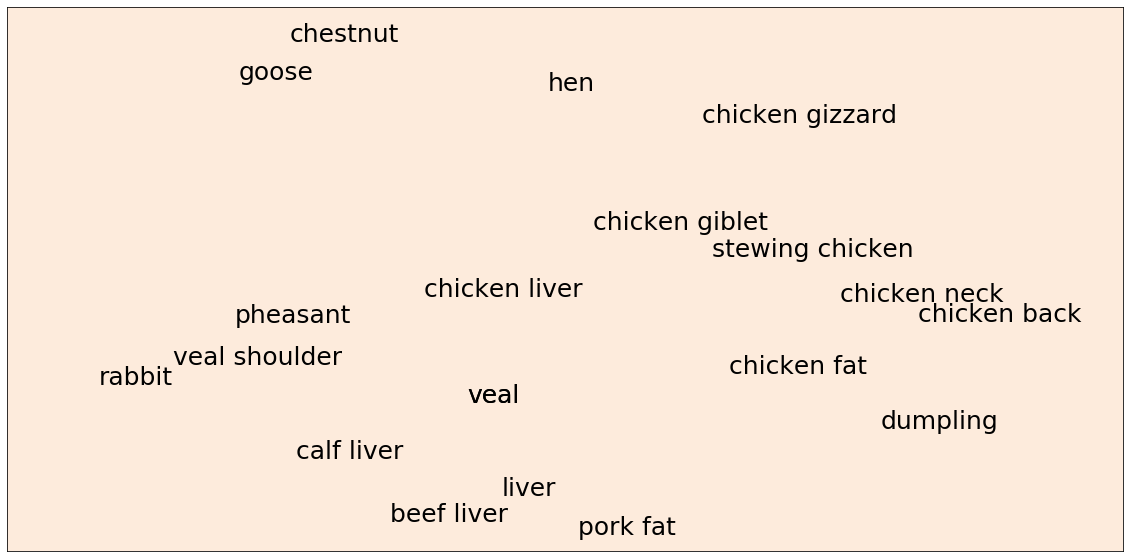

In [102]:
names_to_keep = ['veal']
vocab = list(model.wv.vocab)
epsilon = 0.1

for n in tqdm.tqdm_notebook(names_to_keep) :
    
    name_loc = food_2d[vocab.index(n)]
    to_plot = [name_loc]
    names = [n]
    
    for e, f in enumerate(food_2d) :
        dist = np.linalg.norm(f - name_loc)
        if (dist <= 4.5) :
            to_plot.append(f)
            names.append(vocab[e])
    
    to_plot = np.array(to_plot)
    plt.rcParams["figure.figsize"] = (20,10)
    plt.rcParams.update({'font.size': 25})
    plt.figure()
    plt.scatter(to_plot[:, 0], to_plot[:, 1], color='#56af31', s=100, alpha=0)
    current_axis = plt.gca()
    current_axis.set_facecolor((float(253/255.0), float(235/255.0), float(220/255.0)))
    current_axis.axes.get_xaxis().set_visible(False)
    current_axis.axes.get_yaxis().set_visible(False)
    plt.xlim(-43, -31)
    
    
    for i, word in enumerate(names):
        if word == 'chicken back' :
            plt.annotate(word, xy=(to_plot[i, 0]+ 2*epsilon, to_plot[i, 1] - 2*epsilon ))
        else :
            plt.annotate(word, xy=(to_plot[i, 0] - 4*epsilon, to_plot[i, 1] - epsilon))

    plt.savefig("tsne_food.png")
    plt.show()